In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np
from tqdm import tqdm
import random

In [2]:
# Setting a Random Seed for reproducibility
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

## Network architecture definition

*Reference:* The following block of code is adapted from the repository: https://github.com/kuangliu/pytorch-cifar

In [3]:
'''ResNet in PyTorch.

For Pre-activation ResNet, see 'preact_resnet.py'.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385
'''
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [4]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        downsample = None
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)


    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        return x

device = 'cuda' if torch.cuda.is_available() else 'cpu'
layers=[1, 1, 1, 1]
net = ResNet(BasicBlock, layers).to(device)
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 16, 16]          73,728
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
           Conv2d-12          [-1, 128, 16, 16]           8,192
      BatchNorm2d-13          [-1, 128, 16, 16]             256
       BasicBlock-14          [-1, 128,

Trainable parameters ~4.9M

## Data Augmentation Step

In [5]:
from torch.utils.data import ConcatDataset
# Load the dataset
# Defining Transformers for train and test set differently
train_transform = transforms.Compose([
    transforms.RandomRotation(10),  # Random rotation within 5 degrees
    transforms.RandomHorizontalFlip(0.5),  # 50% chance of horizontal flip
    transforms.RandomCrop(32, padding=4),  # Random crop with padding
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Randomly jitter color properties
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random translation of 10%
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])
# Normal transformation for original images
normal_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])





train_dataset_transformed = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_dataset_normal = datasets.CIFAR10(root='./data', train=True, download=True, transform=normal_transform)

# Concatenate the two datasets
# This steps adds transformed version of the CIFAR10 dataset to itself - increasing the number of datapoints that our model can learn from
combined_dataset = ConcatDataset([train_dataset_transformed, train_dataset_normal])
train_loader = torch.utils.data.DataLoader(combined_dataset, batch_size=64, shuffle=True)
train_dataset=combined_dataset





# Concatenate the two datasets
test_transform = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean = [0.4914, 0.4822, 0.4465],
                                                std = [0.2023, 0.1994, 0.2010])
                       ])
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=6)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/home/sa8237/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


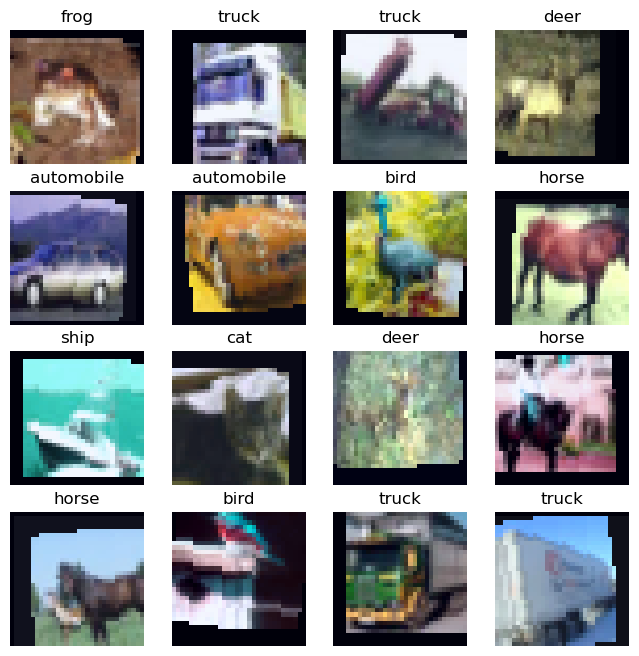

In [6]:
# Checking the data is loaded correctly
def plot_images(images, labels, classes, normalize = False):
    n_images = len(images)
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))
    fig = plt.figure(figsize = (8, 8))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)       
        image = images[i]
        if normalize:
            image_min = image.min()
            image_max = image.max()
            image.clamp_(min = image_min, max = image_max)
            image.add_(-image_min).div_(image_max - image_min + 1e-5)
        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        ax.set_title(classes[labels[i]])
        ax.axis('off')

N_IMAGES = 16
images, labels = zip(*[(image, label) for image, label in [train_dataset[i] for i in range(N_IMAGES)]])
classes = test_dataset.classes
plot_images(images, labels, classes, normalize = True)

## ResNet Training

In [7]:
def train(data_loader, model, criterion, optimizer, scheduler = None, early_stop=None):
    learning_rate_tracker = {}
    epoch_correct = 0
    running_loss = 0.0
    model.train()
    for i, (images, labels) in tqdm(enumerate(data_loader)):
        learning_rate_tracker[i] = optimizer.param_groups[0]['lr']

        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        predicted = torch.max(outputs.data, 1)[1]
        epoch_correct += (predicted == labels).sum().item()

        if early_stop and i==early_stop:
            break

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()


    return epoch_correct , running_loss, learning_rate_tracker

def evaluate(data_loader, model, criterion):
    epoch_correct = 0
    running_loss = 0.0
    y_true = []
    y_pred = []
    model.eval()
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            epoch_correct += (predicted == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return epoch_correct, running_loss, y_true, y_pred

In [8]:
# Define the hyperparameter grid
learning_rates = np.logspace(-2, -5, num=4)  # We train the network on 4*3*10 epochs
momentums = np.linspace(0.7, 0.9, num=3)     
step_size = (len(train_dataset)/64) // 2
epochs = 10
criterion = nn.CrossEntropyLoss()


accuracy_grid = {}
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []
y_pred = []
y_true = []

for lr in learning_rates:
    for momentum in momentums:
        print(f"Training with lr={lr} and momentum={momentum}")

        # Initialize the model and optimizer with the current set of hyperparameters
        model = net 
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=True)
        scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr, max_lr=lr * 10, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
        best_validation_accuracy = 0
        
        # Training and evaluation loop
        for epoch in range(epochs):
            print(f"Epoch: {epoch+1}/{epochs}")
            correct, loss, _ = train(data_loader=train_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler)
            accuracy = correct / len(train_loader.dataset)
            loss = loss / len(train_loader)
            train_loss = loss
            train_acc_history.append(accuracy)
            train_loss_history.append(loss)
            
            # evaluation loop
            correct, loss, y_true_large, y_pred_large = evaluate(data_loader=test_loader, model=model, criterion=criterion)
            validation_accuracy = correct / len(test_loader.dataset)
            validation_loss = loss / len(test_loader)
            print(f"Train Accuracy: {accuracy*100:.2f}%")
            print(f"Test Accuracy: {validation_accuracy*100:.2f}%")
            # Update the best parameters if the current run is better
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                torch.save(model.state_dict(), 'gridinorder.pt')
            val_acc_history.append(validation_accuracy)
            val_loss_history.append(validation_loss)

        accuracy_grid[(lr, momentum)] = best_validation_accuracy


Training with lr=0.01 and momentum=0.7
Epoch: 1/10


1563it [01:07, 23.12it/s]


Train Accuracy: 56.06%
Test Accuracy: 76.48%
Epoch: 2/10


1563it [01:07, 23.26it/s]


Train Accuracy: 74.18%
Test Accuracy: 82.50%
Epoch: 3/10


1563it [01:07, 23.24it/s]


Train Accuracy: 79.75%
Test Accuracy: 84.59%
Epoch: 4/10


1563it [01:07, 23.15it/s]


Train Accuracy: 83.15%
Test Accuracy: 85.80%
Epoch: 5/10


1563it [01:07, 23.16it/s]


Train Accuracy: 85.60%
Test Accuracy: 86.77%
Epoch: 6/10


1563it [01:07, 23.26it/s]


Train Accuracy: 87.79%
Test Accuracy: 87.32%
Epoch: 7/10


1563it [01:07, 23.21it/s]


Train Accuracy: 89.22%
Test Accuracy: 88.29%
Epoch: 8/10


1563it [01:07, 23.16it/s]


Train Accuracy: 90.50%
Test Accuracy: 88.72%
Epoch: 9/10


1563it [01:07, 23.15it/s]


Train Accuracy: 91.54%
Test Accuracy: 88.86%
Epoch: 10/10


1563it [01:07, 23.19it/s]


Train Accuracy: 92.13%
Test Accuracy: 89.07%
Training with lr=0.01 and momentum=0.8
Epoch: 1/10


1563it [01:07, 23.12it/s]


Train Accuracy: 86.81%
Test Accuracy: 88.72%
Epoch: 2/10


1563it [01:07, 23.22it/s]


Train Accuracy: 89.62%
Test Accuracy: 89.73%
Epoch: 3/10


1563it [01:07, 23.09it/s]


Train Accuracy: 91.45%
Test Accuracy: 90.05%
Epoch: 4/10


1563it [01:07, 23.21it/s]


Train Accuracy: 92.50%
Test Accuracy: 90.17%
Epoch: 5/10


1563it [01:07, 23.15it/s]


Train Accuracy: 93.42%
Test Accuracy: 90.29%
Epoch: 6/10


1563it [01:07, 23.13it/s]


Train Accuracy: 94.12%
Test Accuracy: 90.71%
Epoch: 7/10


1563it [01:07, 23.18it/s]


Train Accuracy: 94.58%
Test Accuracy: 90.74%
Epoch: 8/10


1563it [01:07, 23.21it/s]


Train Accuracy: 94.89%
Test Accuracy: 90.84%
Epoch: 9/10


1563it [01:07, 23.08it/s]


Train Accuracy: 95.28%
Test Accuracy: 90.86%
Epoch: 10/10


1563it [01:07, 23.22it/s]


Train Accuracy: 95.63%
Test Accuracy: 91.12%
Training with lr=0.01 and momentum=0.9
Epoch: 1/10


1563it [01:07, 23.20it/s]


Train Accuracy: 89.74%
Test Accuracy: 90.03%
Epoch: 2/10


1563it [01:07, 23.24it/s]


Train Accuracy: 92.22%
Test Accuracy: 90.64%
Epoch: 3/10


1563it [01:07, 23.19it/s]


Train Accuracy: 93.41%
Test Accuracy: 90.73%
Epoch: 4/10


1563it [01:07, 23.19it/s]


Train Accuracy: 94.34%
Test Accuracy: 91.23%
Epoch: 5/10


1563it [01:07, 23.19it/s]


Train Accuracy: 94.90%
Test Accuracy: 91.33%
Epoch: 6/10


1563it [01:07, 23.17it/s]


Train Accuracy: 95.44%
Test Accuracy: 91.51%
Epoch: 7/10


1563it [01:07, 23.15it/s]


Train Accuracy: 95.89%
Test Accuracy: 91.65%
Epoch: 8/10


1563it [01:07, 23.12it/s]


Train Accuracy: 96.31%
Test Accuracy: 91.71%
Epoch: 9/10


1563it [01:07, 23.24it/s]


Train Accuracy: 96.41%
Test Accuracy: 92.10%
Epoch: 10/10


1563it [01:07, 23.12it/s]


Train Accuracy: 96.75%
Test Accuracy: 92.04%
Training with lr=0.001 and momentum=0.7
Epoch: 1/10


1563it [01:07, 23.20it/s]


Train Accuracy: 97.28%
Test Accuracy: 92.33%
Epoch: 2/10


1563it [01:07, 23.17it/s]


Train Accuracy: 97.32%
Test Accuracy: 92.19%
Epoch: 3/10


1563it [01:07, 23.23it/s]


Train Accuracy: 97.41%
Test Accuracy: 92.28%
Epoch: 4/10


1563it [01:07, 23.22it/s]


Train Accuracy: 97.58%
Test Accuracy: 92.33%
Epoch: 5/10


1563it [01:07, 23.18it/s]


Train Accuracy: 97.55%
Test Accuracy: 92.47%
Epoch: 6/10


1563it [01:07, 23.15it/s]


Train Accuracy: 97.57%
Test Accuracy: 92.48%
Epoch: 7/10


1563it [01:07, 23.23it/s]


Train Accuracy: 97.62%
Test Accuracy: 92.53%
Epoch: 8/10


1563it [01:07, 23.23it/s]


Train Accuracy: 97.65%
Test Accuracy: 92.42%
Epoch: 9/10


1563it [01:07, 23.30it/s]


Train Accuracy: 97.62%
Test Accuracy: 92.45%
Epoch: 10/10


1563it [01:07, 23.19it/s]


Train Accuracy: 97.76%
Test Accuracy: 92.55%
Training with lr=0.001 and momentum=0.8
Epoch: 1/10


1563it [01:07, 23.21it/s]


Train Accuracy: 97.60%
Test Accuracy: 92.47%
Epoch: 2/10


1563it [01:07, 23.22it/s]


Train Accuracy: 97.68%
Test Accuracy: 92.43%
Epoch: 3/10


1563it [01:05, 23.87it/s]


Train Accuracy: 97.80%
Test Accuracy: 92.53%
Epoch: 4/10


1563it [01:01, 25.61it/s]


Train Accuracy: 97.78%
Test Accuracy: 92.51%
Epoch: 5/10


1563it [01:00, 25.69it/s]


Train Accuracy: 97.76%
Test Accuracy: 92.61%
Epoch: 6/10


1563it [01:01, 25.62it/s]


Train Accuracy: 97.83%
Test Accuracy: 92.74%
Epoch: 7/10


1563it [01:00, 25.68it/s]


Train Accuracy: 97.78%
Test Accuracy: 92.66%
Epoch: 8/10


1563it [01:00, 25.64it/s]


Train Accuracy: 97.88%
Test Accuracy: 92.71%
Epoch: 9/10


1563it [01:00, 25.66it/s]


Train Accuracy: 97.88%
Test Accuracy: 92.65%
Epoch: 10/10


1563it [01:00, 25.66it/s]


Train Accuracy: 97.84%
Test Accuracy: 92.66%
Training with lr=0.001 and momentum=0.9
Epoch: 1/10


1563it [01:00, 25.65it/s]


Train Accuracy: 97.76%
Test Accuracy: 92.71%
Epoch: 2/10


1563it [01:01, 25.61it/s]


Train Accuracy: 97.82%
Test Accuracy: 92.65%
Epoch: 3/10


1563it [01:00, 25.70it/s]


Train Accuracy: 97.77%
Test Accuracy: 92.59%
Epoch: 4/10


1563it [01:01, 25.61it/s]


Train Accuracy: 97.93%
Test Accuracy: 92.62%
Epoch: 5/10


1563it [01:00, 25.70it/s]


Train Accuracy: 97.89%
Test Accuracy: 92.63%
Epoch: 6/10


1563it [01:00, 25.65it/s]


Train Accuracy: 97.95%
Test Accuracy: 92.65%
Epoch: 7/10


1563it [01:00, 25.67it/s]


Train Accuracy: 97.99%
Test Accuracy: 92.66%
Epoch: 8/10


1563it [01:01, 25.60it/s]


Train Accuracy: 98.00%
Test Accuracy: 92.63%
Epoch: 9/10


1563it [01:00, 25.69it/s]


Train Accuracy: 98.06%
Test Accuracy: 92.79%
Epoch: 10/10


1563it [01:01, 25.54it/s]


Train Accuracy: 98.06%
Test Accuracy: 92.76%
Training with lr=9.999999999999999e-05 and momentum=0.7
Epoch: 1/10


1563it [01:01, 25.59it/s]


Train Accuracy: 98.03%
Test Accuracy: 92.65%
Epoch: 2/10


1563it [01:00, 25.65it/s]


Train Accuracy: 98.12%
Test Accuracy: 92.74%
Epoch: 3/10


1563it [01:01, 25.59it/s]


Train Accuracy: 98.16%
Test Accuracy: 92.71%
Epoch: 4/10


1563it [01:00, 25.66it/s]


Train Accuracy: 98.15%
Test Accuracy: 92.69%
Epoch: 5/10


1563it [01:01, 25.62it/s]


Train Accuracy: 98.18%
Test Accuracy: 92.77%
Epoch: 6/10


1563it [01:00, 25.66it/s]


Train Accuracy: 98.22%
Test Accuracy: 92.75%
Epoch: 7/10


1563it [01:01, 25.61it/s]


Train Accuracy: 98.20%
Test Accuracy: 92.86%
Epoch: 8/10


1563it [01:01, 25.56it/s]


Train Accuracy: 98.17%
Test Accuracy: 92.70%
Epoch: 9/10


1563it [01:00, 25.66it/s]


Train Accuracy: 98.12%
Test Accuracy: 92.70%
Epoch: 10/10


1563it [01:00, 25.69it/s]


Train Accuracy: 98.10%
Test Accuracy: 92.76%
Training with lr=9.999999999999999e-05 and momentum=0.8
Epoch: 1/10


1563it [01:00, 25.65it/s]


Train Accuracy: 98.19%
Test Accuracy: 92.73%
Epoch: 2/10


1563it [01:00, 25.69it/s]


Train Accuracy: 98.14%
Test Accuracy: 92.68%
Epoch: 3/10


1563it [01:00, 25.65it/s]


Train Accuracy: 98.13%
Test Accuracy: 92.74%
Epoch: 4/10


1563it [01:01, 25.61it/s]


Train Accuracy: 98.18%
Test Accuracy: 92.73%
Epoch: 5/10


1563it [01:00, 25.68it/s]


Train Accuracy: 98.15%
Test Accuracy: 92.72%
Epoch: 6/10


1563it [01:00, 25.67it/s]


Train Accuracy: 98.16%
Test Accuracy: 92.81%
Epoch: 7/10


1563it [01:00, 25.64it/s]


Train Accuracy: 98.14%
Test Accuracy: 92.78%
Epoch: 8/10


1563it [01:00, 25.65it/s]


Train Accuracy: 98.24%
Test Accuracy: 92.72%
Epoch: 9/10


1563it [01:01, 25.59it/s]


Train Accuracy: 98.15%
Test Accuracy: 92.74%
Epoch: 10/10


1563it [01:00, 25.64it/s]


Train Accuracy: 98.20%
Test Accuracy: 92.73%
Training with lr=9.999999999999999e-05 and momentum=0.9
Epoch: 1/10


1563it [01:00, 25.67it/s]


Train Accuracy: 98.19%
Test Accuracy: 92.64%
Epoch: 2/10


1563it [01:00, 25.68it/s]


Train Accuracy: 98.13%
Test Accuracy: 92.73%
Epoch: 3/10


1563it [01:00, 25.67it/s]


Train Accuracy: 98.19%
Test Accuracy: 92.72%
Epoch: 4/10


1563it [01:01, 25.61it/s]


Train Accuracy: 98.20%
Test Accuracy: 92.75%
Epoch: 6/10


1563it [01:00, 25.68it/s]


Train Accuracy: 98.23%
Test Accuracy: 92.68%
Epoch: 7/10


1563it [01:00, 25.67it/s]


Train Accuracy: 98.20%
Test Accuracy: 92.75%
Epoch: 8/10


1563it [01:01, 25.60it/s]


Train Accuracy: 98.20%
Test Accuracy: 92.72%
Epoch: 5/10


1563it [01:00, 25.66it/s]


Train Accuracy: 98.29%
Test Accuracy: 92.65%
Epoch: 6/10


1563it [01:00, 25.65it/s]


Train Accuracy: 98.22%
Test Accuracy: 92.76%
Epoch: 7/10


1563it [01:00, 25.73it/s]


Train Accuracy: 98.16%
Test Accuracy: 92.79%
Epoch: 8/10


1563it [01:00, 25.67it/s]


Train Accuracy: 98.25%
Test Accuracy: 92.75%
Epoch: 9/10


1563it [01:00, 25.72it/s]


Train Accuracy: 98.24%
Test Accuracy: 92.70%
Epoch: 10/10


1563it [01:02, 24.83it/s]


Train Accuracy: 98.22%
Test Accuracy: 92.73%


### Plotting Accuracy against learning rate and momentum

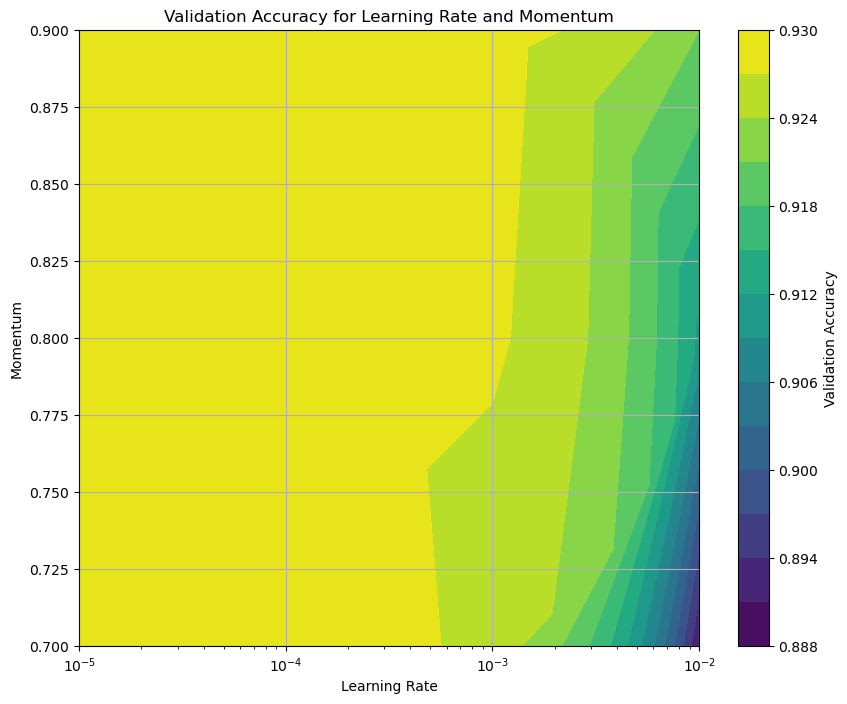

In [9]:
lrs, moms, accs = zip(*[(key[0], key[1], val) for key, val in accuracy_grid.items()])
lrs = np.array(lrs)
moms = np.array(moms)
accs = np.array(accs)

# Create a contour plot
plt.figure(figsize=(10, 8))
plt.tricontourf(lrs, moms, accs, levels=14, cmap='viridis')
plt.colorbar(label='Validation Accuracy')
plt.xscale('log')
plt.xlabel('Learning Rate')
plt.ylabel('Momentum')
plt.title('Validation Accuracy for Learning Rate and Momentum')
plt.grid(True)
plt.show()

### Confusion matrix for predictions

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'airplane'),
  Text(1, 0, 'automobile'),
  Text(2, 0, 'bird'),
  Text(3, 0, 'cat'),
  Text(4, 0, 'deer'),
  Text(5, 0, 'dog'),
  Text(6, 0, 'frog'),
  Text(7, 0, 'horse'),
  Text(8, 0, 'ship'),
  Text(9, 0, 'truck')])

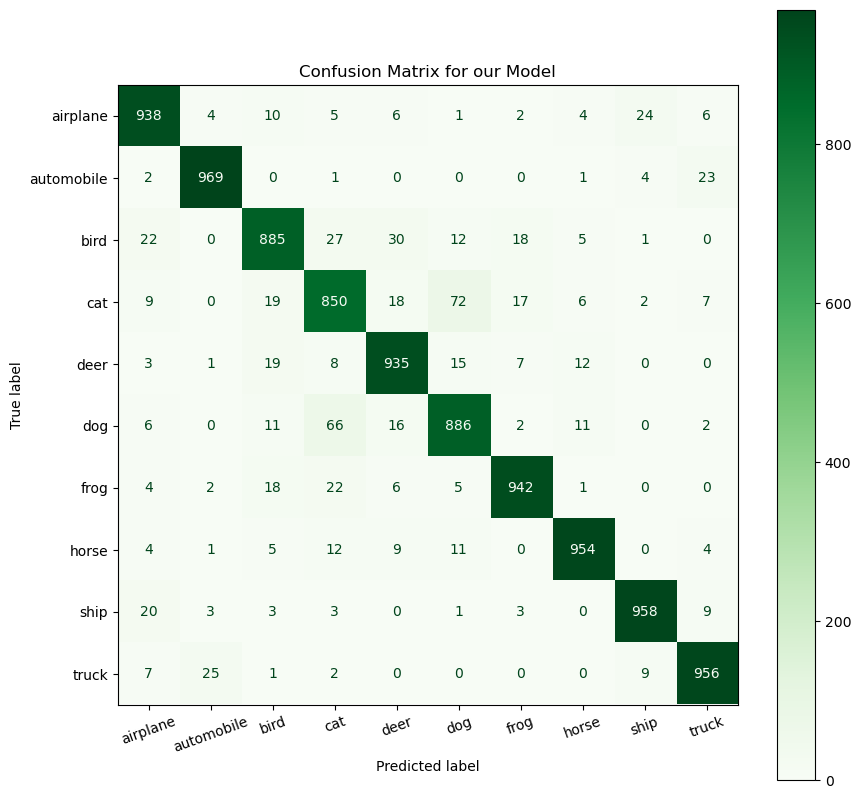

In [12]:
# Calculate the confusion matrix
cm = confusion_matrix(y_true_large, y_pred_large)
fig = plt.figure(figsize = (10, 10));
ax = fig.add_subplot(1, 1, 1);
ax.set_title('Confusion Matrix for our Model')
cm = ConfusionMatrixDisplay(cm, display_labels = classes);
cm.plot(values_format = 'd', cmap = 'Greens', ax = ax)
plt.xticks(rotation = 20)

### Plotting the change in train, validation loss and accuracy over epochs

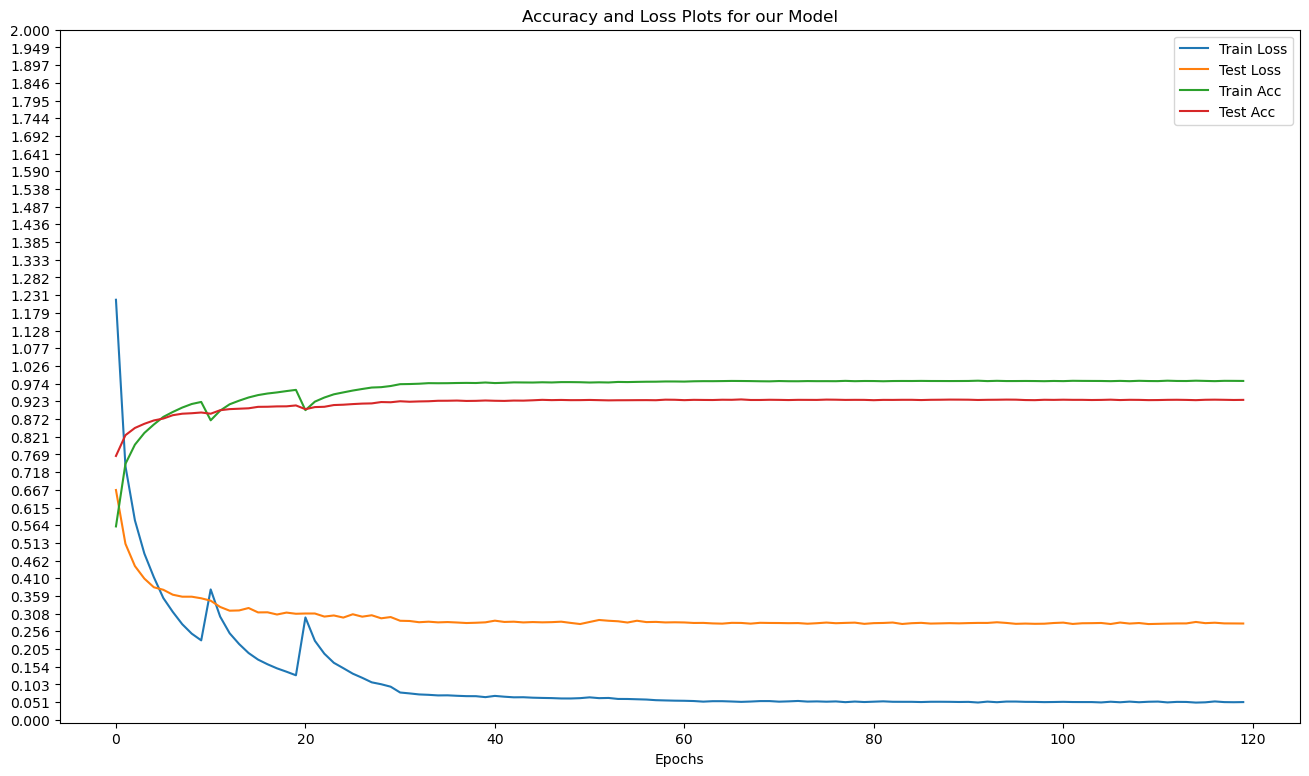

In [13]:
fig, ax = plt.subplots(figsize=(16,9))

plt.title('Accuracy and Loss Plots for our Model')
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Test Loss')
plt.plot(train_acc_history, label='Train Acc')  
plt.plot(val_acc_history, label='Test Acc')
plt.legend()
plt.xlabel("Epochs")
yticks = np.linspace(0, 2.0, num=40)
ax.set_yticks(yticks)
plt.show()

*Comment:* We can see that the graph smooothens after a few epochs as the learning rate reduces and the model improves

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_state_dict = torch.load('gridinorder.pt')

model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [15]:
model.eval()

model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
  )
  (layer2): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128,

In [16]:
correct = 0
total = 0
with torch.no_grad():  # No need to compute gradients during evaluation
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Accuracy of the network on the validation set: {100 * correct / total}%')

/home/sa8237/.local/lib/python3.11/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy of the network on the validation set: 92.79%


#### Final accuracy of our model on CIFAR 10: 92.79%

## Making Inference on unseen data

In [17]:
import pickle

# Load the pickled test data
with open('cifar_test_nolabels.pkl', 'rb') as file:
    test_images = pickle.load(file)

# Checking the type and shape of the loaded data
print(type(test_images))

<class 'dict'>


In [18]:
# Retrieve and print a couple of keys
keys = list(test_images.keys())
sample_key_values = {key: test_images[key] for key in keys}

# Check the type and shape of the image data for these keys
for key, value in sample_key_values.items():
    print(f"Key: {key}, Type: {type(value)}, Shape: {value.shape if hasattr(value, 'shape') else 'N/A'}")

Key: b'data', Type: <class 'numpy.ndarray'>, Shape: (10000, 3072)
Key: b'ids', Type: <class 'numpy.ndarray'>, Shape: (10000,)


In [19]:
import torch
from torchvision import transforms
from PIL import Image
import csv
# import pandas as pd

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])



# Process all images for predictions
predictions = []
for i in range(len(test_images[b'data'])):
    # Reshape and transpose image data to (32, 32, 3)
    image_data = test_images[b'data'][i].reshape(3,32,32).transpose([1, 2, 0])
    image_data = transform(image_data).unsqueeze(0)  # Add batch dimension

    image_data = image_data.to(device)
    # Convert to PIL Image
    # Make prediction
    with torch.no_grad():
        output = model(image_data)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()
        predictions.append((test_images[b'ids'][i], predicted_label))



In [20]:
y_values = [y for _, y in predictions]

# Converting the list of y values to a set to remove duplicates
unique_y_values = set(y_values)

# Counting the number of unique y values
num_unique_y_values = len(unique_y_values)

print("Number of unique y values:", num_unique_y_values)

Number of unique y values: 10


In [ ]:
frequency = {}

# Looping through the list to count each y value
for _, y in predictions:
    if y in frequency:
        frequency[y] += 1
    else:
        frequency[y] = 1

# Printing the frequency of each y value
for y_val, count in frequency.items():
    print(f"Frequency of {y_val}: {count}")

In [ ]:
import csv
csv_file_path = 'predictions_ResNet.csv'

# Write the predictions into the CSV file
with open(csv_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(['ID', 'Labels'])  # Write the header
    for prediction in predictions:
        writer.writerow(prediction)
# Return the path to the saved CSV file
csv_file_path